Design and implement a system that combines the power of YOLO for real-time object detection, ResNet for image classification, and image retrieval techniques to find the top-k similar images to the detected objects in a given image.

In [1]:
!pip3 install ultralytics

# Dataset

source: https://www.kaggle.com/datasets/nguyngiabol/colorful-fashion-dataset-for-object-detection

The classes of the this dataset -sunglass, hat, jacket, shirt, pants, shorts, skirt, dress, bag, shoe

The folder contains:
- JPEGImages
    - contains image files ```<Img-Number>.jpg, e.g. 1.jpg```
- labels.txt (list of classes. they will referred as 0 to 9 in Annotations.txt)
- Annotations_txt
    - ```<Img-Number>.txt, e.g. 1.txt``` which contains class and bounding box pos/dim for the corresponding image in JPEGImages folder in below format. Each line is a an object with class and its bounding box center and dimensions.
        ```{object_class_id} {x_center} {y_center} {width} {height}```
- ImageSets
    - Main/tainval.txt (image numbers for training)
    - Main/test.txt (image numbers for testing)
- Annotations
    - Contains the annotations in xml format. Each file ```<Img-Number>.xml, e.g. 1.xml``` corresponds to image in JPEGImages folder.

Note: If you want .txt file with YOLO format, you can use Annotations_txt directory

# Kaggle setup

    On your Kaggle account, under API, select "Create New API Token" and kaggle.json will be downloaded on your computer.

    Go to directory — "${user.home}\.kaggle\" — and move here the downloaded JSON file.

In [2]:
from kaggle.api.kaggle_api_extended import KaggleApi

k_api = KaggleApi()
k_api.authenticate()

In [3]:
from zipfile import ZipFile
import os
import shutil
from zipfile import ZipFile

os.makedirs('./.data', exist_ok = True)

if not os.path.exists('./.data/colorful-fashion-dataset-for-object-detection.zip'):
    #downloading datasets for ny stock exchange
    k_api.dataset_download_files(
        dataset='nguyngiabol/colorful-fashion-dataset-for-object-detection',
        unzip=False
    )
    shutil.move('colorful-fashion-dataset-for-object-detection.zip', './.data')

    zf = ZipFile('./.data/colorful-fashion-dataset-for-object-detection.zip')
    zf.extractall('./.data/colorful-fashion-dataset-for-object-detection/') 
    zf.close()
    
root_dir = './.data/colorful-fashion-dataset-for-object-detection/colorful_fashion_dataset_for_object_detection'
annotations_dir = os.path.join(root_dir, 'Annotations_txt')
images_dir = os.path.join(root_dir, 'JPEGImages')
labels_file = os.path.join(root_dir, 'labels.txt')

print(root_dir, annotations_dir, images_dir, labels_file, sep="\n")

./.data/colorful-fashion-dataset-for-object-detection/colorful_fashion_dataset_for_object_detection
./.data/colorful-fashion-dataset-for-object-detection/colorful_fashion_dataset_for_object_detection/Annotations_txt
./.data/colorful-fashion-dataset-for-object-detection/colorful_fashion_dataset_for_object_detection/JPEGImages
./.data/colorful-fashion-dataset-for-object-detection/colorful_fashion_dataset_for_object_detection/labels.txt


# Data Exploration

## Get label to int index

In [4]:
import os

label_to_int = {}
int_to_label = {}
f = open(labels_file, 'r')
for i, line in enumerate(f.readlines()):
    label = line.split(',')[0]
    int_to_label[i] = label
    label_to_int[label] = i
f.close()
print(label_to_int)
print(int_to_label)

{'sunglass': 0, 'hat': 1, 'jacket': 2, 'shirt': 3, 'pants': 4, 'shorts': 5, 'skirt': 6, 'dress': 7, 'bag': 8, 'shoe': 9}
{0: 'sunglass', 1: 'hat', 2: 'jacket', 3: 'shirt', 4: 'pants', 5: 'shorts', 6: 'skirt', 7: 'dress', 8: 'bag', 9: 'shoe'}


In [5]:
import os
import pandas as pd

class_file_df = pd.DataFrame(columns=["class", "file"])

for f in os.listdir(annotations_dir):
    if not f.endswith(".txt"):
        continue
    annotation_file = open(os.path.join(annotations_dir, f), 'r')
    for line in annotation_file.readlines():
        obj_class = line.split()[0]
        # annotation file contains both int and char as the label
        # mapping all the ints to names, for visualization
        if obj_class.isdigit():
            obj_class = int_to_label[int(obj_class)]
        class_file_df.loc[len(class_file_df)] = [obj_class, f]
    annotation_file.close()

class_file_df.head(5)

,class,file
0,bag,47145.txt
1,shirt,47145.txt
2,jacket,47145.txt
3,shoe,47145.txt
4,shorts,47145.txt


In [6]:
class_file_df["class"].unique()

array(['bag', 'shirt', 'jacket', 'shoe', 'shorts', 'sunglass', 'pants',
       'hat', 'dress', 'skirt'], dtype=object)

## Plot class count

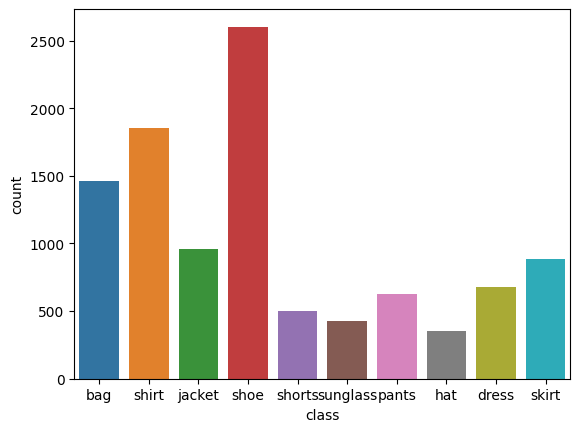

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='class', data=class_file_df)
plt.show()

There is a class imbalance, does this needs to be addressed ?

## Randomly visualize few images with bounding boxes

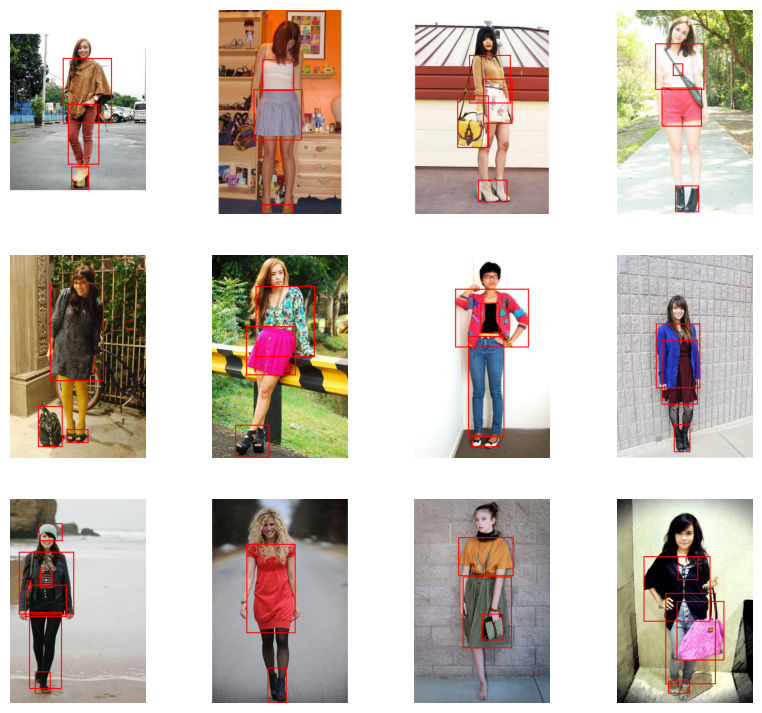

In [8]:
import os
import numpy as np
from PIL import Image, ImageDraw

import matplotlib.pyplot as plt

def get_boxes(img_name):
    boxes = []
    annotations_name = img_name.split('.')[0]+'.txt'
    f = open(os.path.join(annotations_dir, annotations_name), 'r')
    for line in f.readlines():
        parts = line.split()
        cls = int_to_label[int(parts[0])] if parts[0].isdigit() else parts[0]
        x, y, w, h = float(parts[1]), float(parts[2]), float(parts[3]), float(parts[4])
        boxes.append((cls, x, y, w, h))
    return boxes

def annotate_image(img: Image, boxes):
    dimg = ImageDraw.Draw(img)
    for box in boxes:
        (iw, ih) = img.size
        (bw, bh) = int(box[3]*iw), int(box[4]*ih)
        (bx_c, by_c) = int(box[1]*iw), int(box[2]*ih)
        dimg.rectangle(
            (bx_c-bw//2, by_c-bh//2, bx_c+bw//2, by_c+bh//2), 
            outline='red', width=3)
        #dimg.text((bx_c-bw//2, by_c-bh//2), box[0])


num_rows = 3
num_columns = 4
num_images_to_view = num_columns * num_rows
fig, axs = plt.subplots(num_rows, num_columns, figsize=(10, 3*num_rows))

fimages = os.listdir(images_dir)
for i, fidx in enumerate(np.random.randint(1, len(fimages), num_images_to_view)):
    img_path = os.path.join(images_dir, fimages[fidx])
    r,c = (i//num_columns, i%num_columns)
    img = Image.open(img_path, "r")
    boxes = get_boxes(fimages[fidx])
    annotate_image(img, boxes)
    axs[r][c].imshow(img)
    axs[r][c].set_axis_off()

plt.show()

## Fix issues with annotations
YOLO expects the annotations to have classes as integers from 0 to n-1, where n is number of classes

In [9]:
import os

updated_annotations_dir = os.path.join(root_dir, "updated_annotations")
os.makedirs(updated_annotations_dir, exist_ok = True)

for f in os.listdir(annotations_dir):
    if not f.endswith('.txt'):
        continue
    
    fread = open(os.path.join(annotations_dir, f), 'r')
    fwrite = open(os.path.join(updated_annotations_dir, f), 'w')
    for line in fread.readlines():
        updated_parts = []
        parts = line.split()
        updated_parts.append(parts[0] if parts[0].isdigit() else str(label_to_int[parts[0]]))
        for i in range(1, len(parts)):
            updated_parts.append(parts[i])
        fwrite.write(' '.join(updated_parts))
        fwrite.write('\n')
    fwrite.close()
    fread.close()

# Train model for object detection

## Prepare YOLO input & config file

In [10]:
import os
import numpy as np
import shutil

yolo_config_dir = os.path.join(root_dir, 'yolo-config')
yolo_detect_file  = os.path.join(yolo_config_dir, "detect.yaml")

yolo_train_dir = os.path.join(yolo_config_dir, "train")
yolo_train_images_dir = os.path.join(yolo_train_dir, "images")
yolo_train_labels_dir = os.path.join(yolo_train_dir, "labels")

yolo_val_dir = os.path.join(yolo_config_dir, "val")
yolo_val_images_dir = os.path.join(yolo_val_dir, "images")
yolo_val_labels_dir = os.path.join(yolo_val_dir, "labels")

yolo_test_dir = os.path.join(yolo_config_dir, "test")
yolo_test_images_dir = os.path.join(yolo_test_dir, "images")
yolo_test_labels_dir = os.path.join(yolo_test_dir, "labels")

os.makedirs(yolo_train_images_dir, exist_ok = True)
os.makedirs(yolo_train_labels_dir, exist_ok = True)
os.makedirs(yolo_val_images_dir, exist_ok = True)
os.makedirs(yolo_val_labels_dir, exist_ok = True)
os.makedirs(yolo_test_images_dir, exist_ok = True)
os.makedirs(yolo_test_labels_dir, exist_ok = True)

def read_data_txt_file(file_name):
    ids = list()
    fread = open(os.path.join(root_dir, 'ImageSets/Main/'+file_name), 'r')
    for line in fread.readlines():
        ids.append(line.split()[0])
    fread.close()
    return ids

train_val_image_ids = read_data_txt_file('trainval.txt')
test_image_ids = read_data_txt_file('test.txt')

trainvalset_len = len(train_val_image_ids)
testset_len = len(test_image_ids)
valset_len = int(0.1*trainvalset_len)
trainset_len = trainvalset_len - valset_len

np.random.shuffle(train_val_image_ids)
val_image_ids = train_val_image_ids[:valset_len]
train_image_ids = train_val_image_ids[valset_len:]

def copy_files(file_names, src_dir, dst_dir, ext='txt'):
    for name in file_names:
        src_file_path = "{}/{}.{}".format(src_dir, name, ext)
        dst_file_path = "{}/{}.{}".format(dst_dir, name, ext)
        if not os.path.exists(dst_file_path):
            shutil.copy2(src_file_path, dst_dir)

copy_files(val_image_ids, images_dir, yolo_val_images_dir, ext='jpg')
copy_files(train_image_ids, images_dir, yolo_train_images_dir, ext='jpg')
copy_files(test_image_ids, images_dir, yolo_test_images_dir, ext='jpg')

copy_files(val_image_ids, updated_annotations_dir, yolo_val_labels_dir)
copy_files(train_image_ids, updated_annotations_dir, yolo_train_labels_dir)
copy_files(test_image_ids, updated_annotations_dir, yolo_test_labels_dir)

yolo_config_file_contents = """
train: ../train/images
val: ../val/images

nc: {}
names: [{}]
""".format(
    len(label_to_int),
    ','.join([ "'{}'".format(x) for x in label_to_int])
)
cfwrite = open(yolo_detect_file, 'w')
cfwrite.write(yolo_config_file_contents)
cfwrite.close()

## Train the model

In [11]:
from ultralytics import YOLO

yolo8_model = YOLO("yolov8m.pt")
yolo8_model.train(data=yolo_detect_file, epochs=30)

Ultralytics YOLOv8.0.178 🚀 Python-3.11.4 torch-2.0.1 CPU (Intel Core(TM) i9-9980HK 2.40GHz)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=./.data/colorful-fashion-dataset-for-object-detection/colorful_fashion_dataset_for_object_detection/yolo-config/detect.yaml, epochs=30, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, augment=False, agn

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x14af05c90>
fitness: 0.7652635882552112
keys: ['metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)']
maps: array([    0.35401,     0.64708,     0.84543,       0.828,     0.86537,     0.74652,     0.87346,     0.88414,     0.74511,     0.67147])
names: {0: 'sunglass', 1: 'hat', 2: 'jacket', 3: 'shirt', 4: 'pants', 5: 'shorts', 6: 'skirt', 7: 'dress', 8: 'bag', 9: 'shoe'}
plot: True
results_dict: {'metrics/precision(B)': 0.9257709836429104, 'metrics/recall(B)': 0.8949334716870935, 'metrics/mAP50(B)': 0.9381091048033335, 'metrics/mAP50-95(B)': 0.7460585308609755, 'fitness': 0.7652635882552112}
save_dir: PosixPath('runs/detect/train7')
speed: {'preprocess': 1.6014705165739982, 'inference': 390.0034430719191, 'loss': 5.383645334